# Creating the Index

### Things to achieve in the notebook
- Take the data and calculate the heat index
    - Work out the daily sentiment score
    - Work out the daily heat count
    - Combine the two!

In [102]:
## Import libraries

import matplotlib.pyplot as plt                               # Used for plotting data
from collections import Counter                               # This is used to count occurances of values
import pandas as pd                                           # Used for cleanly displaying data
import numpy as np                                            # Collection of mathematical functions
import tarfile                                                # Used for extracting files
import json                                                   # Processing individual JSON files uses this
import csv                                                    # This was used to create and read csvs
import string
import pickle
import os                                                     # This helped locate and delete json files
import re
import math
from ast import literal_eval                                  # Used to convert strings to dict
from datetime import datetime                                 # This processes different date formats
from pandas.plotting import register_matplotlib_converters    # This had to be registered to allow for timeseries plots
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from emoji import demojize
from langdetect import detect
from multiprocessing import Process
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from matplotlib.patches import Rectangle
from sklearn.metrics import  confusion_matrix
register_matplotlib_converters()
pd.set_option('display.max_rows', 10)                         # Setting displayed panda length

In [103]:
# For ease of indexing

timestamp = 1
ID = 0
place = 2
text = 3
loc = 4
sentiment = 5
coord = 6

## Create the Index (Functions)

### Daily tweet count

In [104]:
def tweetcounter(filename):

    tweetcount = Counter()                                              # Initialise counter
    with open(filename,'r', encoding='utf-8') as csvfile:       # Run through lines of csv
        read = csv.reader(csvfile)
        for line in read:
            ts = literal_eval(line[timestamp])/1000                              # Convert timestamps to ms                     
            Date = datetime.utcfromtimestamp(ts).date()                 # Turn ts into date
            tweetcount[Date] +=1
        
    return(tweetcount)

### Sentiment Calculations

In [105]:
def sentcalc(filename, tweetcount):

    df = pd.DataFrame.from_dict(tweetcount, orient = 'index')
    df.index.name = 'Date'
    df.columns = ['Count']
    df['sentpos'] = np.empty((len(df), 0)).tolist()
    df['sentneg'] = np.empty((len(df), 0)).tolist()

    with open(filename,'r', encoding='utf-8') as csvfile:       # Run through lines of csv
        read = csv.reader(csvfile)
        for line in read:
            ts = int(literal_eval(line[timestamp]))/1000                              # Convert timestamps to ms                     
            Date = (datetime.utcfromtimestamp(ts).date())                 # Turn ts into date
            if float(line[sentiment]) > 0.05:
                df.at[Date, 'sentpos'] = np.append(df.at[Date, 'sentpos'], float(line[sentiment]))            
            if float(line[sentiment]) < -0.05:
                df.at[Date, 'sentneg'] = np.append(df.at[Date, 'sentneg'], float(line[sentiment]))
                
    return(df)

### Calculate the Index

In [106]:
def indexcalc(df):    
    
    df['sent_score'] = 0
    df['ETF'] = 0


    for i in range(len(df)):
        ETI_count = df.iloc[i]['Count']


        T_neg = len(df.iloc[i]['sentneg'])
        T_pos = len(df.iloc[i]['sentpos'])
        if T_pos != 0:
            R = T_neg/T_pos
        else:
            R = T_neg

        if len(df.iloc[i]['sentneg']) == 0:
            maxi = 0
        else:
            maxi = min(df.iloc[i]['sentneg'])

        ETI_sent = R*maxi*100
        df['sent_score'][i] = ETI_sent

        ETF = abs(ETI_count*ETI_sent)

        df['ETF'][i] = ETF
        
        return(df)

# Calculate the Index

## Canada

In [155]:
filename = 'HeatCanadaCSV.csv'

canadacount = tweetcounter(filename)
df_can = sentcalc(filename, canadacount)

In [156]:
df_can['sent_score'] = 0
df_can['ETF'] = 0


for i in range(len(df_can)):
    ETI_count = round(df_can.iloc[i]['Count'], -2)


    T_neg = len(df_can.iloc[i]['sentneg'])
    T_pos = len(df_can.iloc[i]['sentpos'])
    if T_pos != 0:
        R = T_neg/T_pos
    else:
        R = T_neg

    if len(df_can.iloc[i]['sentneg']) == 0:
        maxi = 0
    else:
        maxi = np.percentile(df_can.iloc[i]['sentneg'], 5)

    ETI_sent = R*maxi*100
    df_can['sent_score'][i] = ETI_sent

    ETF = abs(ETI_count*ETI_sent)

    df_can['ETF'][i] = ETF
    

C:\Users\beckr\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\beckr\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [157]:
df_can.head()

,Count,sentpos,sentneg,sent_score,ETF
Date,,,,,
2018-06-01,13,"[0.3182, 0.6486, 0.4404, 0.3802, 0.3182, 0.648...",[],0,0
2018-06-17,58,"[0.5248, 0.8126, 0.5248, 0.8126, 0.5248, 0.8126]","[-0.3945, -0.8442, -0.296, -0.6486, -0.6486, -...",-436,43617
2018-06-18,95,"[0.5023, 0.3612, 0.6114, 0.765, 0.3182, 0.4926...","[-0.5267, -0.9367, -0.296, -0.3049, -0.5267, -...",-23,2391
2018-06-19,35,"[0.6369, 0.6369, 0.0516, 0.3182, 0.4215, 0.636...","[-0.6249, -0.6973, -0.34, -0.6249, -0.6973, -0...",-36,0
2018-06-20,33,"[0.7096, 0.1511, 0.8126, 0.5983, 0.7096, 0.151...","[-0.4215, -0.4215, -0.4215]",-10,0


### Plots

In [158]:
df_can = df_can.reset_index()
df_can = df_can.sort_values(by='Date')

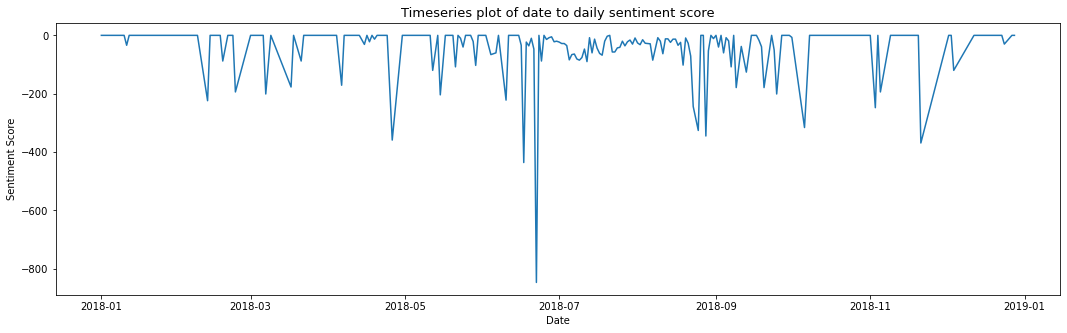

In [159]:
plt.figure(figsize = [18,5])
plt.plot(df_can['Date'],df_can['sent_score'])
plt.title('Timeseries plot of date to daily sentiment score', size = 13)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

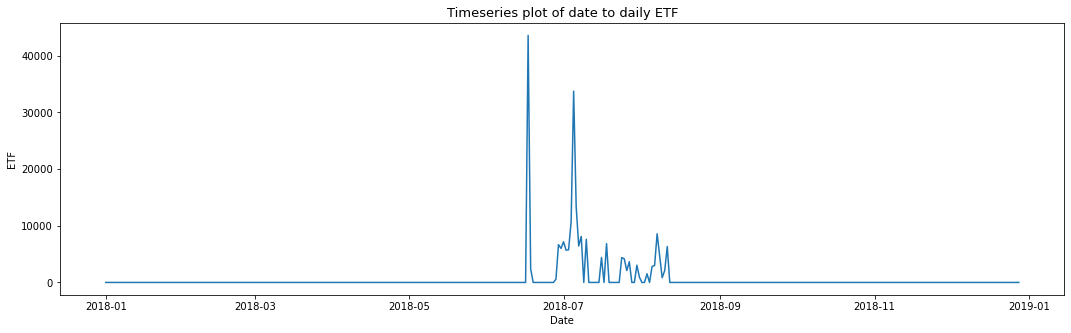

In [160]:
plt.figure(figsize = [18,5])
plt.plot(df_can['Date'],df_can['ETF'])
plt.title('Timeseries plot of date to daily ETF', size = 13)
plt.xlabel('Date')
plt.ylabel('ETF')
plt.show()

### Save the data

In [12]:
savedata = {}
savedata['table_ETFcan'] = df_can

with open('df_can.pkl', 'wb') as outfile:
    pickle.dump(savedata, outfile)

## UK

In [13]:
filename = 'HeatUKCSV.csv'

UKcount = tweetcounter(filename)
df_uk = sentcalc(filename, UKcount)

In [14]:
df_uk['sent_score'] = 0
df_uk['ETF'] = 0


for i in range(len(df_uk)):
    ETI_count = df_uk.iloc[i]['Count']


    T_neg = len(df_uk.iloc[i]['sentneg'])
    T_pos = len(df_uk.iloc[i]['sentpos'])
    if T_pos != 0:
        R = T_neg/T_pos
    else:
        R = T_neg

    if len(df_uk.iloc[i]['sentneg']) == 0:
        maxi = 0
    else:
        maxi = min(df_uk.iloc[i]['sentneg'])

    ETI_sent = R*maxi*100
    df_uk['sent_score'][i] = ETI_sent

    ETF = abs(ETI_count*ETI_sent)

    df_uk['ETF'][i] = ETF
    

C:\Users\beckr\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\beckr\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
df_uk.head()

,Count,sentpos,sentneg,sent_score,ETF
Date,,,,,
2018-06-02,86,"[0.7783, 0.2023, 0.2023, 0.2023, 0.4939, 0.636...","[-0.0516, -0.0516, -0.5719, -0.6597, -0.0516, ...",-32,2836
2018-06-03,59,"[0.6486, 0.5697, 0.6486, 0.4215, 0.7592, 0.303...","[-0.7227, -0.7227, -0.5023, -0.5023, -0.3447, ...",-48,2842
2018-06-06,20,"[0.2263, 0.3774, 0.7494, 0.5267, 0.2263, 0.377...","[-0.5499, -0.5499]",-13,274
2018-06-07,28,"[0.5267, 0.6249, 0.4668, 0.4215, 0.25, 0.8745,...","[-0.3182, -0.1027, -0.2023, -0.3182, -0.1027, ...",-12,356
2018-06-10,24,"[0.7003, 0.4927, 0.4927, 0.7003, 0.7269, 0.492...","[-0.6124, -0.6124]",-15,367


### Plots

In [16]:
df_uk = df_uk.reset_index()
df_uk = df_uk.sort_values(by='Date')

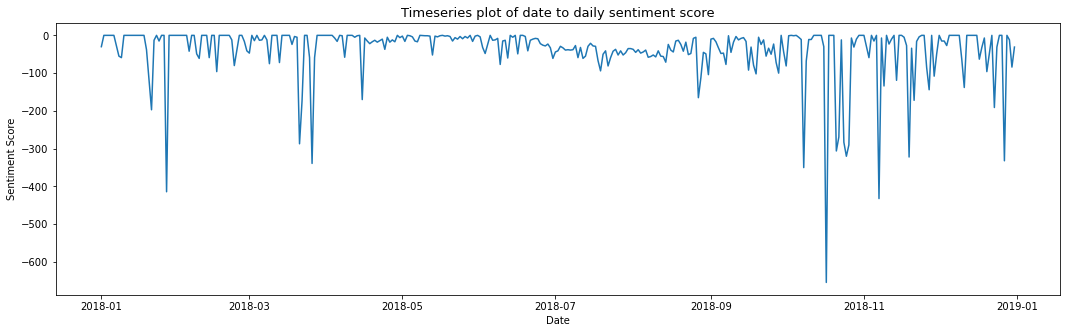

In [17]:
plt.figure(figsize = [18,5])
plt.plot(df_uk['Date'],df_uk['sent_score'])
plt.title('Timeseries plot of date to daily sentiment score', size = 13)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

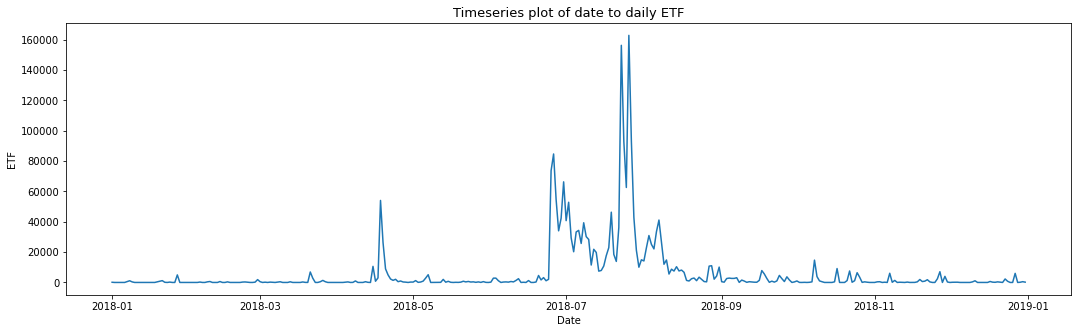

In [18]:
plt.figure(figsize = [18,5])
plt.plot(df_uk['Date'],df_uk['ETF'])
plt.title('Timeseries plot of date to daily ETF', size = 13)
plt.xlabel('Date')
plt.ylabel('ETF')
plt.show()

### Save the data

In [19]:
savedata = {}
savedata['table_ETFuk'] = df_uk

with open('df_uk.pkl', 'wb') as outfile:
    pickle.dump(savedata, outfile)

## Ireland

In [20]:
filename = 'HeatIrelandCSV.csv'

Irelandcount = tweetcounter(filename)
df_ir = sentcalc(filename, Irelandcount)

In [21]:
df_ir['sent_score'] = 0
df_ir['ETF'] = 0


for i in range(len(df_ir)):
    ETI_count = df_ir.iloc[i]['Count']


    T_neg = len(df_ir.iloc[i]['sentneg'])
    T_pos = len(df_ir.iloc[i]['sentpos'])
    if T_pos != 0:
        R = T_neg/T_pos
    else:
        R = T_neg

    if len(df_ir.iloc[i]['sentneg']) == 0:
        maxi = 0
    else:
        maxi = min(df_ir.iloc[i]['sentneg'])

    ETI_sent = R*maxi*100
    df_ir['sent_score'][i] = ETI_sent

    ETF = abs(ETI_count*ETI_sent)

    df_ir['ETF'][i] = ETF
    

C:\Users\beckr\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\beckr\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
df_ir.head()

,Count,sentpos,sentneg,sent_score,ETF
Date,,,,,
2018-06-01,12,"[0.8513, 0.8513, 0.8513]","[-0.4939, -0.4939, -0.4412, -0.6331, -0.4939, ...",-147,1772
2018-06-02,7,[],"[-0.5574, -0.5574]",-111,780
2018-06-04,20,"[0.6249, 0.5558, 0.7579, 0.5558, 0.7579]",[],0,0
2018-06-08,27,"[0.743, 0.8644, 0.7269, 0.7269, 0.743, 0.8644,...","[-0.34, -0.2975, -0.34, -0.2975]",-15,408
2018-06-09,17,"[0.3818, 0.7579, 0.4404, 0.0772, 0.3818, 0.757...",[],0,0


### Plots

In [23]:
df_ir = df_ir.reset_index()
df_ir = df_ir.sort_values(by='Date')

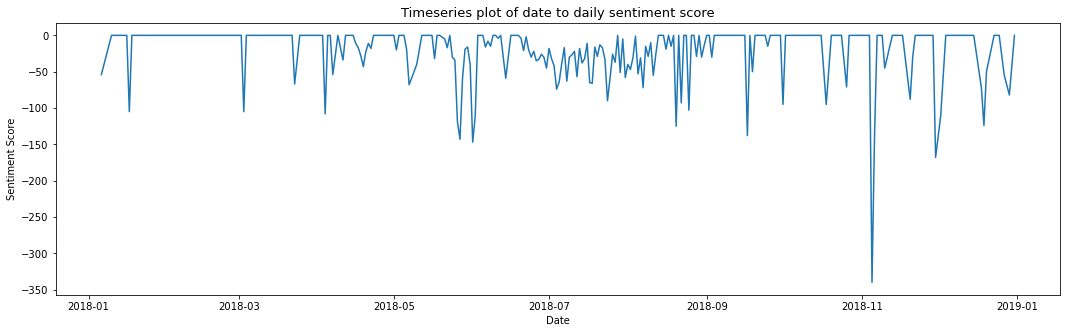

In [24]:
plt.figure(figsize = [18,5])
plt.plot(df_ir['Date'],df_ir['sent_score'])
plt.title('Timeseries plot of date to daily sentiment score', size = 13)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

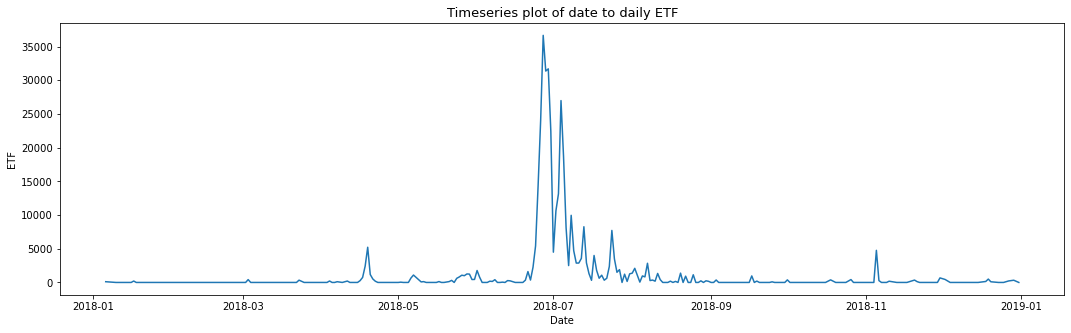

In [25]:
plt.figure(figsize = [18,5])
plt.plot(df_ir['Date'],df_ir['ETF'])
plt.title('Timeseries plot of date to daily ETF', size = 13)
plt.xlabel('Date')
plt.ylabel('ETF')
plt.show()

### Save the data

In [26]:
savedata = {}
savedata['table_ETFir'] = df_ir

with open('df_ir.pkl', 'wb') as outfile:
    pickle.dump(savedata, outfile)

## Sweden

In [27]:
filename = 'HeatSwedenCSV.csv'

Swedencount = tweetcounter(filename)
df_sw = sentcalc(filename, Swedencount)

In [28]:
df_sw['sent_score'] = 0
df_sw['ETF'] = 0


for i in range(len(df_sw)):
    ETI_count = df_sw.iloc[i]['Count']


    T_neg = len(df_sw.iloc[i]['sentneg'])
    T_pos = len(df_sw.iloc[i]['sentpos'])
    if T_pos != 0:
        R = T_neg/T_pos
    else:
        R = T_neg

    if len(df_sw.iloc[i]['sentneg']) == 0:
        maxi = 0
    else:
        maxi = min(df_sw.iloc[i]['sentneg'])

    ETI_sent = R*maxi*100
    df_sw['sent_score'][i] = ETI_sent

    ETF = abs(ETI_count*ETI_sent)

    df_sw['ETF'][i] = ETF
    

C:\Users\beckr\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\beckr\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
df_sw.head()

,Count,sentpos,sentneg,sent_score,ETF
Date,,,,,
2018-06-02,11,"[0.2003, 0.5267, 0.2003, 0.3818, 0.5267, 0.200...",[],0,0
2018-06-30,1,[],[],0,0
2018-07-05,6,"[0.9371, 0.9371]",[],0,0
2018-07-06,4,[],[],0,0
2018-07-16,29,"[0.7096, 0.3609, 0.3182, 0.2263, 0.4144, 0.709...","[-0.34, -0.34, -0.34, -0.34, -0.34, -0.34, -0....",-100,2912


### Plots

In [30]:
df_sw = df_sw.reset_index()
df_sw = df_sw.sort_values(by='Date')

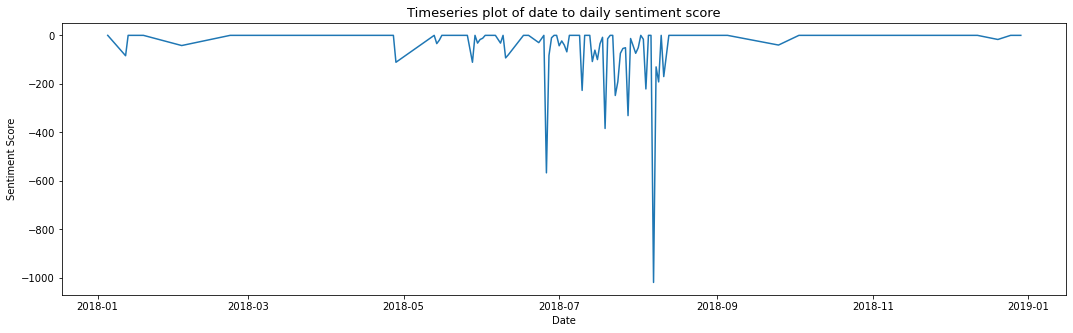

In [31]:
plt.figure(figsize = [18,5])
plt.plot(df_sw['Date'],df_sw['sent_score'])
plt.title('Timeseries plot of date to daily sentiment score', size = 13)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

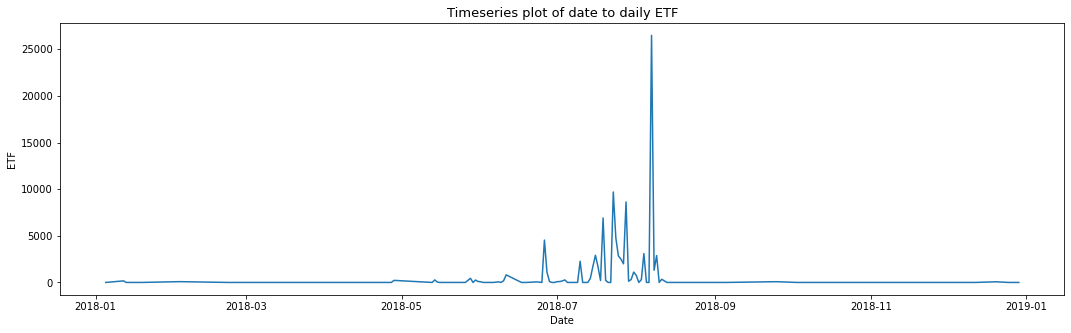

In [32]:
plt.figure(figsize = [18,5])
plt.plot(df_sw['Date'],df_sw['ETF'])
plt.title('Timeseries plot of date to daily ETF', size = 13)
plt.xlabel('Date')
plt.ylabel('ETF')
plt.show()

### Save the data

In [33]:
savedata = {}
savedata['table_ETFsw'] = df_sw

with open('df_sw.pkl', 'wb') as outfile:
    pickle.dump(savedata, outfile)

## India

In [34]:
filename = 'HeatIndiaCSV.csv'

Indiacount = tweetcounter(filename)
df_in = sentcalc(filename, Indiacount)

In [35]:
df_in['sent_score'] = 0
df_in['ETF'] = 0


for i in range(len(df_in)):
    ETI_count = df_in.iloc[i]['Count']


    T_neg = len(df_in.iloc[i]['sentneg'])
    T_pos = len(df_in.iloc[i]['sentpos'])
    if T_pos != 0:
        R = T_neg/T_pos
    else:
        R = T_neg

    if len(df_in.iloc[i]['sentneg']) == 0:
        maxi = 0
    else:
        maxi = min(df_in.iloc[i]['sentneg'])

    ETI_sent = R*maxi*100
    df_in['sent_score'][i] = ETI_sent

    ETF = abs(ETI_count*ETI_sent)

    df_in['ETF'][i] = ETF
    

C:\Users\beckr\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\beckr\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [36]:
df_in.head()

,Count,sentpos,sentneg,sent_score,ETF
Date,,,,,
2018-06-02,26,"[0.6983, 0.6983, 0.6983, 0.6597, 0.6983, 0.557...","[-0.6124, -0.4588, -0.4939, -0.0935, -0.6908, ...",-70,1839
2018-06-04,24,"[0.3182, 0.3182, 0.3182, 0.3182]","[-0.6908, -0.6908, -0.5423, -0.5423, -0.6908, ...",-120,2901
2018-06-11,9,"[0.6369, 0.6369, 0.8316, 0.6369, 0.8316]","[-0.3182, -0.3182]",-12,114
2018-06-15,6,[],"[-0.1615, -0.1615]",-32,193
2018-06-17,6,"[0.4404, 0.4404]",[],0,0


### Plots

In [37]:
df_in = df_in.reset_index()
df_in = df_in.sort_values(by='Date')

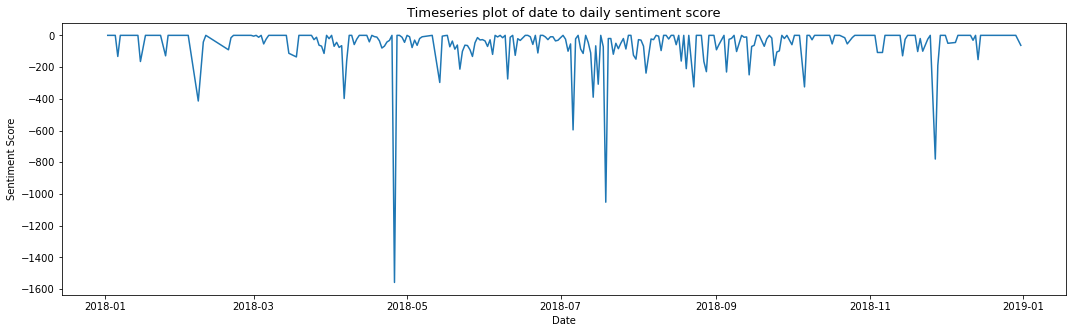

In [38]:
plt.figure(figsize = [18,5])
plt.plot(df_in['Date'],df_in['sent_score'])
plt.title('Timeseries plot of date to daily sentiment score', size = 13)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

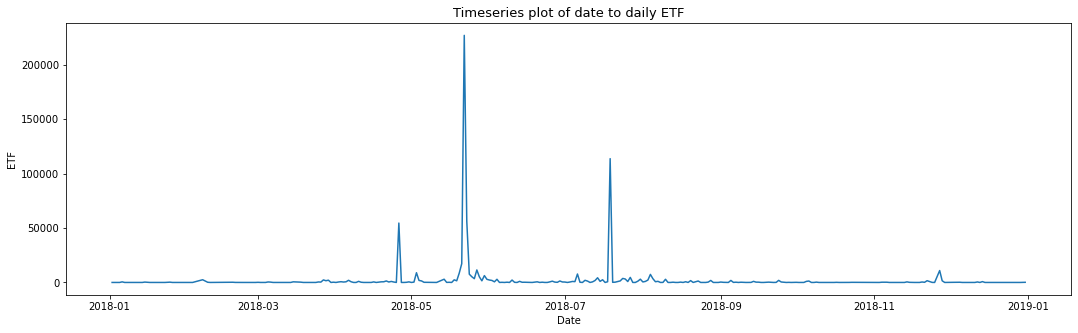

In [39]:
plt.figure(figsize = [18,5])
plt.plot(df_in['Date'],df_in['ETF'])
plt.title('Timeseries plot of date to daily ETF', size = 13)
plt.xlabel('Date')
plt.ylabel('ETF')
plt.show()

### Save the data

In [40]:
savedata = {}
savedata['table_ETFin'] = df_in

with open('df_in.pkl', 'wb') as outfile:
    pickle.dump(savedata, outfile)

## Texas

In [42]:
filename = 'HeatTexasCSV.csv'

Texascount = tweetcounter(filename)
df_tx = sentcalc(filename, Texascount)

In [43]:
df_tx['sent_score'] = 0
df_tx['ETF'] = 0


for i in range(len(df_tx)):
    ETI_count = df_tx.iloc[i]['Count']


    T_neg = len(df_tx.iloc[i]['sentneg'])
    T_pos = len(df_tx.iloc[i]['sentpos'])
    if T_pos != 0:
        R = T_neg/T_pos
    else:
        R = T_neg

    if len(df_tx.iloc[i]['sentneg']) == 0:
        maxi = 0
    else:
        maxi = min(df_tx.iloc[i]['sentneg'])

    ETI_sent = R*maxi*100
    df_tx['sent_score'][i] = ETI_sent

    ETF = abs(ETI_count*ETI_sent)

    df_tx['ETF'][i] = ETF
    

C:\Users\beckr\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\beckr\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [44]:
df_tx.head()

,Count,sentpos,sentneg,sent_score,ETF
Date,,,,,
2018-08-06,2,[0.3612],[],0,0
2018-01-09,1,[0.2023],[],0,0
2018-01-19,1,[],[-0.3412],-34,34
2018-01-29,1,[0.4588],[],0,0
2018-03-05,1,[],[],0,0


### Plots

In [45]:
df_tx = df_tx.reset_index()
df_tx = df_tx.sort_values(by='Date')

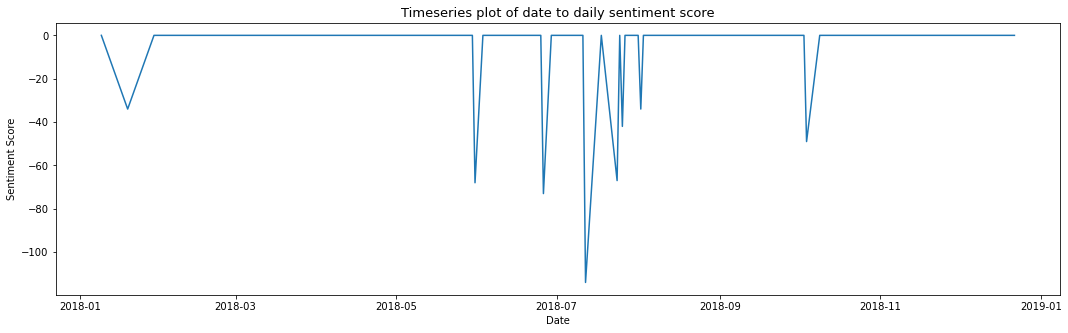

In [46]:
plt.figure(figsize = [18,5])
plt.plot(df_tx['Date'],df_tx['sent_score'])
plt.title('Timeseries plot of date to daily sentiment score', size = 13)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

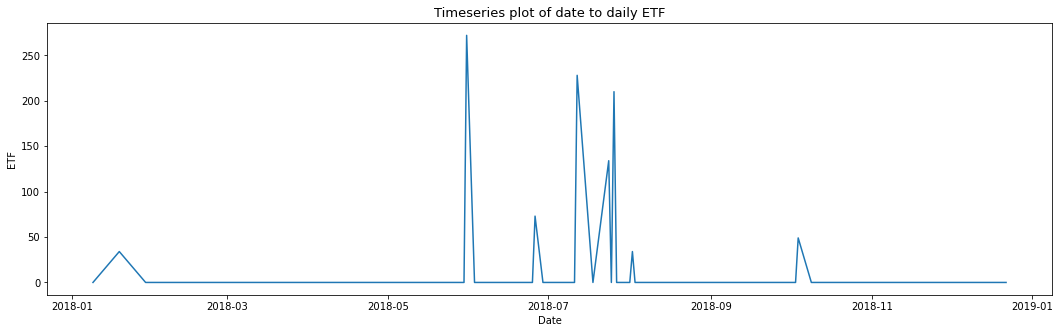

In [47]:
plt.figure(figsize = [18,5])
plt.plot(df_tx['Date'],df_tx['ETF'])
plt.title('Timeseries plot of date to daily ETF', size = 13)
plt.xlabel('Date')
plt.ylabel('ETF')
plt.show()

### Save the data

In [48]:
savedata = {}
savedata['table_ETFtx'] = df_tx

with open('df_tx.pkl', 'wb') as outfile:
    pickle.dump(savedata, outfile)

## Australia

In [49]:
filename = 'HeatAustraliaCSV.csv'

Australiacount = tweetcounter(filename)
df_au = sentcalc(filename, Australiacount)

In [50]:
df_au['sent_score'] = 0
df_au['ETF'] = 0


for i in range(len(df_au)):
    ETI_count = df_au.iloc[i]['Count']


    T_neg = len(df_au.iloc[i]['sentneg'])
    T_pos = len(df_au.iloc[i]['sentpos'])
    if T_pos != 0:
        R = T_neg/T_pos
    else:
        R = T_neg

    if len(df_au.iloc[i]['sentneg']) == 0:
        maxi = 0
    else:
        maxi = min(df_au.iloc[i]['sentneg'])

    ETI_sent = R*maxi*100
    df_au['sent_score'][i] = ETI_sent

    ETF = abs(ETI_count*ETI_sent)

    df_au['ETF'][i] = ETF
    

C:\Users\beckr\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\beckr\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
df_au.head()

,Count,sentpos,sentneg,sent_score,ETF
Date,,,,,
2018-01-03,16,"[0.6249, 0.3182, 0.6249, 0.3182, 0.6249, 0.3182]","[-0.4588, -0.4588, -0.5574, -0.4588, -0.4588, ...",-92,1486
2018-01-06,458,"[0.6696, 0.8225, 0.6696, 0.8225, 0.3182, 0.273...","[-0.5423, -0.5423, -0.5423, -0.5423, -0.1027, ...",-193,88524
2018-01-07,327,"[0.3182, 0.3182, 0.3612, 0.4939, 0.729, 0.3182...","[-0.5423, -0.5423, -0.5423, -0.5423, -0.5423, ...",-107,34996
2018-01-08,125,"[0.128, 0.128, 0.3182, 0.128, 0.765, 0.4337, 0...","[-0.6597, -0.7906, -0.4939, -0.2732, -0.5994, ...",-66,8273
2018-01-09,472,"[0.3182, 0.3818, 0.3818, 0.3818, 0.3818, 0.381...","[-0.2263, -0.2263, -0.4939, -0.5423, -0.5563, ...",-401,189317


### Plots

In [52]:
df_au = df_au.reset_index()
df_au = df_au.sort_values(by='Date')

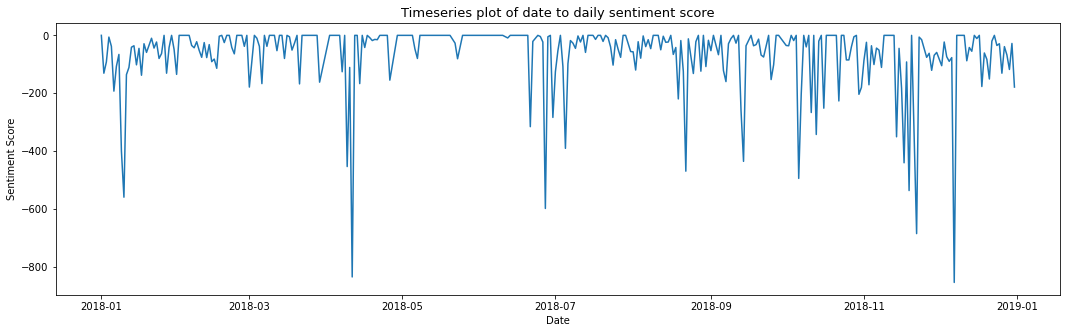

In [53]:
plt.figure(figsize = [18,5])
plt.plot(df_au['Date'],df_au['sent_score'])
plt.title('Timeseries plot of date to daily sentiment score', size = 13)
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.show()

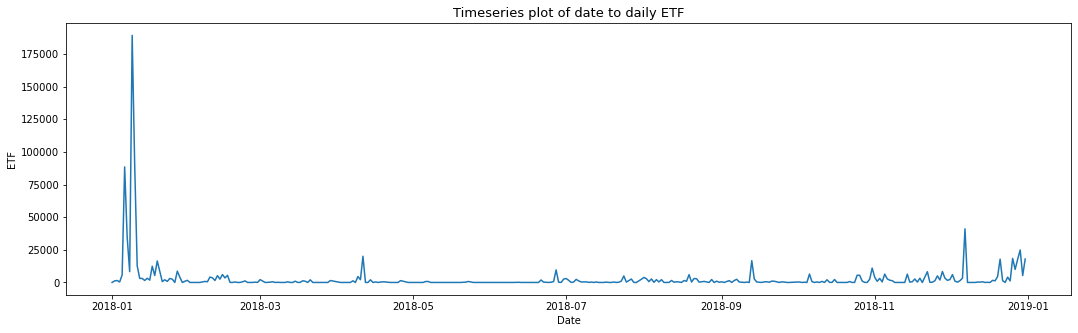

In [54]:
plt.figure(figsize = [18,5])
plt.plot(df_au['Date'],df_au['ETF'])
plt.title('Timeseries plot of date to daily ETF', size = 13)
plt.xlabel('Date')
plt.ylabel('ETF')
plt.show()

### Save the data

In [55]:
savedata = {}
savedata['table_ETFau'] = df_au

with open('df_au.pkl', 'wb') as outfile:
    pickle.dump(savedata, outfile)